<h1>Navigation<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Calculating-Beta" data-toc-modified-id="Calculating-Beta-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculating Beta</a></span></li><li><span><a href="#CAPM" data-toc-modified-id="CAPM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CAPM</a></span></li><li><span><a href="#Company’s-key-financial-indicators,-estimating-future-dividend-flows-and-calculating-the-stock-price-based-on-DDM" data-toc-modified-id="Company’s-key-financial-indicators,-estimating-future-dividend-flows-and-calculating-the-stock-price-based-on-DDM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Company’s key financial indicators, estimating future dividend flows and calculating the stock price based on DDM</a></span></li></ul></div>

In [60]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import requests
import matplotlib.pyplot as plt

In [151]:
import warnings
warnings.filterwarnings('ignore')

# Data

Let's load the data on Yandex and IMOEX index quotations. In the future I will lead the dataframes to the form "date - yield".

In [2]:
GAZP = pd.read_csv("GAZP.csv")
IMOEX = pd.read_csv("IMOEX.csv")

In [3]:
GAZP = GAZP[['Дата', 'Изм. %']]
d = {'Дата': 'Date',
    'Изм. %': 'GAZP_Return_daily'}

GAZP.rename(columns = d, inplace = True)

GAZP['GAZP_Return_daily'] = GAZP['GAZP_Return_daily'].str[:-1]
GAZP['GAZP_Return_daily'] = GAZP['GAZP_Return_daily'].str.replace(',', '.')
GAZP['GAZP_Return_daily'] = pd.to_numeric(GAZP['GAZP_Return_daily'])

IMOEX = IMOEX[['Дата', 'Изм. %']]
d = {'Дата': 'Date',
    'Изм. %': 'IMOEX_Return_daily'}

IMOEX.rename(columns = d, inplace = True)

IMOEX['IMOEX_Return_daily'] = IMOEX['IMOEX_Return_daily'].str[:-1]
IMOEX['IMOEX_Return_daily'] = IMOEX['IMOEX_Return_daily'].str.replace(',', '.')
IMOEX['IMOEX_Return_daily'] = pd.to_numeric(IMOEX['IMOEX_Return_daily'])

I downloaded the Russian Government Bond Zero Coupon Yield Curve, Values (% per annum) separately from the Central Bank website. 

In [4]:
# https://stackoverflow.com/questions/23377533/python-beautifulsoup-parsing-table - решение отсюда

url = " https://www.cbr.ru/eng/hd_base/zcyc_params/?UniDbQuery.Posted=True&UniDbQuery.From=03.12.2016&UniDbQuery.To=03.12.2021"

r = requests.get(url)
df_list = pd.read_html(r.text)
df = df_list[0]
df = df.droplevel(level=0, axis=1)

I'll take the data on 10-year zero-coupon bonds.

In [152]:
GB = df[['Date', '10']]

d = {'Date': 'Date',
    '10': 'GB_Return'}

GB.rename(columns = d, inplace = True)

Let's see what we've got.

In [6]:
data = GAZP.merge(IMOEX, 'right')
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by='Date', inplace = True)

In [7]:
data

,Date,GAZP_Return_daily,IMOEX_Return_daily
1263,2016-05-12,0.94,1.38
1262,2016-06-12,-1.48,-0.28
1261,2016-07-12,0.30,0.38
1260,2016-08-12,0.72,2.15
1259,2016-09-12,-0.04,0.07
...,...,...,...
146,2021-12-05,-0.29,0.06
103,2021-12-07,0.74,0.53
80,2021-12-08,0.99,0.30
37,2021-12-10,-1.54,-0.38


In [153]:
GB['Date'] = pd.to_datetime(GB['Date'])
GB.sort_values(by='Date', inplace = True)
GB

,Date,GB_Return
1259,2016-05-12,8.78
1258,2016-06-12,8.73
1257,2016-07-12,8.66
1256,2016-08-12,8.60
1255,2016-09-12,8.53
...,...,...
146,2021-12-05,7.27
103,2021-12-07,7.22
80,2021-12-08,7.10
37,2021-12-10,7.59


# Calculating Beta

Variance-Covariance матрица. 

In [9]:
cov = data.cov()
cov

,GAZP_Return_daily,IMOEX_Return_daily
GAZP_Return_daily,2.623168,1.266283
IMOEX_Return_daily,1.266283,1.184331


To calculate the beta, we need the covariance between the stock returns and the market index and the variation of the market index returns.

In [144]:
cov_GAZP_IMOEX = cov['GAZP_Return_daily']['IMOEX_Return_daily']
var_IMOEX = cov['IMOEX_Return_daily']['IMOEX_Return_daily']

print(f'covariance is equal to {cov_GAZP_IMOEX}')
print(f'variance is equal to {var_IMOEX}')

covariance is equal to 1.2662828931642565
variance is equal to 1.184330991047536


In [145]:
beta = cov_GAZP_IMOEX / var_IMOEX
print(f'beta is equal to {beta}')

beta is equal to 1.0691967893572003


To make sure the calculations are correct, I will also calculate the beta through linear regression: we should get the same result. 

In [12]:
X = data['IMOEX_Return_daily'].to_numpy().reshape(-1, 1)
Y = data['GAZP_Return_daily'].to_numpy().reshape(-1, 1)

linreg = LinearRegression()
linreg.fit(X, Y)

linreg.coef_[0, 0]

1.0691967893571996

Text(0, 0.5, 'GAZP_Return_daily')

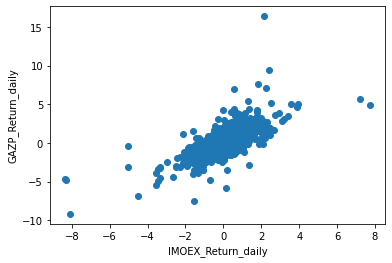

In [63]:
plt.scatter(data['IMOEX_Return_daily'].to_numpy(), data['GAZP_Return_daily'].to_numpy())
plt.xlabel('IMOEX_Return_daily')
plt.ylabel('GAZP_Return_daily')

# CAPM

In [146]:
risk_free_return = float(GB.mean()) / 100
print(f'risk free rate is equal to {risk_free_return}')

risk free rate is equal to 0.07416896825396832


In [147]:
market_return = 0.151
print(f'market rate is equal to {market_return}')

market rate is equal to 0.151


In [148]:
expected_return = risk_free_return + beta * (market_return - risk_free_return)
print(f'requaired rate is equal to {expected_return}')

requaired rate is equal to 0.15631646071982652


# Company’s key financial indicators, estimating future dividend flows and calculating the stock price based on DDM

In [105]:
ROE = {2013: 0.12224, 2014: 0.01620,
       2015: 0.08443, 2016: 0.08577, 2017: 0.06142,
       2018: 0.109, 2019: 0.085, 2020: 0.009}
payout_ration = {2013: 0.54, 2014: 0.15, 2015: 0.15,
                 2016: 0.18, 2017: 0.09, 
                 2018: 0.31, 2019: 3.4, 2020: 0.25}
dividends = {2018: 16.61, 2019: 15.24, 2020: 12.55}

In [106]:
fin_data = pd.DataFrame([ROE, payout_ration, dividends], index=['ROE', 'payout_ratio', 'dividends'])
fin_data = fin_data.T

In [107]:
fin_data

,ROE,payout_ratio,dividends
2013,0.12224,0.54,NaN
2014,0.01620,0.15,NaN
2015,0.08443,0.15,NaN
2016,0.08577,0.18,NaN
2017,0.06142,0.09,NaN
2018,0.10900,0.31,16.61
2019,0.08500,3.40,15.24
2020,0.00900,0.25,12.55


In [108]:
fin_data['g'] = fin_data['ROE'] * (1 - fin_data['payout_ratio'])

In [109]:
fin_data

,ROE,payout_ratio,dividends,g
2013,0.12224,0.54,NaN,0.056230
2014,0.01620,0.15,NaN,0.013770
2015,0.08443,0.15,NaN,0.071765
2016,0.08577,0.18,NaN,0.070331
2017,0.06142,0.09,NaN,0.055892
2018,0.10900,0.31,16.61,0.075210
2019,0.08500,3.40,15.24,-0.204000
2020,0.00900,0.25,12.55,0.006750


In [137]:
g_1 = np.mean([0.056230, 0.013770, 0.071765, 0.070331, 0.055892, 0.075210, 0, 0.006750])
g_1

0.043743500000000005

In [138]:
g_2 = 0.1 * 0.4
g_2

0.04000000000000001

In [149]:
# for the next years 

div_2021 = 12.55 * (1 + g_1)
div_2022 = div_2021 * (1 + g_1)
div_2023 = div_2022 * (1 + g_1)
div_2024 = div_2023 * (1 + g_2)
div_2025 = div_2024 * (1 + g_2)
div_2026 = div_2025 * (1 + g_2)

print(f'2021 year - div = {div_2021}')
print(f'2022 year - div = {div_2022}')
print(f'2023 year - div = {div_2023}')
print(f'2024 year - div = {div_2024}')
print(f'2025 year - div = {div_2025}')
print(f'2026 year - div = {div_2026}')

2021 year - div = 13.098980925
2022 year - div = 13.671976197092736
2023 year - div = 14.27003628787026
2024 year - div = 14.840837739385071
2025 year - div = 15.434471248960474
2026 year - div = 16.051850098918894


In [140]:
# for the terminal period 

div = div_2023 / g_2
print(f'terminal period - div = {div}')

terminal period - div = 356.75090719675643


In [150]:
# by 2020

stock_value = (div_2021 / (expected_return + 1) ** 1) \
            + (div_2022 / (expected_return + 1) ** 2) \
            + (div_2023 / (expected_return + 1) ** 3) \
            + (((div_2023 * (1 + g_2)) / (expected_return - g_2)) / (expected_return + 1) ** 3)
print(f'stock_value is equal to {stock_value}')

stock_value is equal to 113.30869698596814
